In [5]:
import RadioSimulator
import datetime
import sys, time, copy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
%matplotlib inline

# Plotting setup
fs = 14
plt.rc('font',family='Times New Roman')
plt.rcParams['axes.formatter.useoffset'] = False
#mpl.rc('text', usetex = True)

Workflow: 
- Run a grid search to identify feasible points
- Save the outcome of the grid search to a csv
- Sort the grid search csv to identify the best-performing solutions

PSO: 
- Define feasible space
- Randomly draw initial points and velocities
- Use the top *n* grid search items to populate some of the starting points for the particles
- For each epoch,
    - Pool particle simulations across the cores
- Every n epochs, save the best location and all of the particle data. 

# Grid Search (Parallel and serial)

In [10]:
## Define the grid
# TEGserialSeries   = np.arange(10,36,5)
# TEGparallelSeries = np.arange(1,22,5)
# battSeries        = np.arange(1,22,5)
# capSeries         = np.arange(1,22,5)
# SOCseries         = np.arange(0.2,0.81,0.2)
# V_bSeries         = np.arange(0, 1.9, 0.4)
# V_cSeries         = np.arange(1.8, 3.5, 0.4)

TEGserialSeries   = [25]
TEGparallelSeries = [5]
battSeries        = np.arange(5,26,10)
capSeries         = np.arange(5,26,10)
SOCseries         = [0.4]
V_bSeries         = np.arange(0,0.9,0.4)
V_cSeries         = [2]

mySim = RadioSimulator.RadioSimulator(radioFile = '../Data/PowerMEMS_Sample_Data_em_20160707.csv')
# mySim = RadioSimulator.RadioSimulator(radioFile = '../Data/50step_downsampled_toy.csv')
outfile = '../Results/gridSearchSuccesses_'+datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")+'.csv'


Approaches for getting around the multiprocessing issue with bound methods. Test with 54 scenarios, chunksize=10:
- base time (on laptop): 235.88s
- Pass a tuple with (initiVariables, mySim) where mySim does not change: took at least 20 minutes; did not complete.
- Use copy.copy(mySim) with the above to get this to work: 320.32s
- Create a new mySim inside of the function - took at least 2hrs; appears to have frozen the system.

In [14]:
#### Parallelized Grid Search ####
import itertools
from multiprocessing import Pool

## The following section preps a list of scenarios for a parallelized grid search. 
#    This could be replaced by nested loops if parallelization is not desired.

# Steps: 
#  - Create a list of lists with all the variables.
#  - Create all combinations of these variable values (combinatorial combinations; same as nested loops
#  - Pack each of these into the initVariables dictionary form
#  - map all of these to a multiprocessing pool
#  - take the output of the pool and pack it into a dataframe
#  - Assign the costs to the dataframe
#  - Save the dataframe
def tupleToDict(a):
    return {'TEGserial':a[0], 'TEGparallel':a[1], 'batts':a[2], 'caps':a[3], 'SOC':a[4], 'V_b':a[5], 'V_c':a[6]}

def processTupleSim(myTuple):
    (initVariable, mySim) = myTuple
    return mySim.computeCost(initVariable)

varList = [TEGserialSeries,TEGparallelSeries, battSeries, capSeries, SOCseries, V_bSeries, V_cSeries]

scenarioList = list(itertools.product(*varList) )   # Create a list of all scenario combinations

scenarioList = [tupleToDict(myTuple) for myTuple in scenarioList]  # Pack them each into dictionaries
scenarioSimTupleList = [(initDict, mySim) for initDict in scenarioList]

print("Number of scenarios: %s"%len(scenarioList))
sys.stdout.flush()

### Prepping for parallel execution
results = pd.DataFrame()  # This currently does not have the cost data; that will be added later
success = pd.DataFrame()
myPool = Pool()

batches = 5
batchSize = int(len(scenarioSimTupleList)/batches)

## Block the problem into batches, so that we can save progress between batches
for j in np.arange(0,len(scenarioSimTupleList),batchSize):
    scenarioResults = pd.DataFrame(scenarioList[j: j+batchSize-1])
    print("Started batch for scenarios %s to %s at %s"%(j, j+batchSize-1, datetime.datetime.now()))
    sys.stdout.flush()
    starttime = time.time()
    scenarioResults['cost'] = myPool.map(processTupleSim, scenarioSimTupleList[j: j+batchSize-1], chunksize=20)
    print("Finished batch in %.2f seconds"%(time.time()-starttime))
    scenarioSuccess =  scenarioResults[ scenarioResults['cost']<float('inf')]
    success = success.append(scenarioSuccess, ignore_index=True)
    success.to_csv(outfile)

print("Done")

Number of scenarios: 27
Started batch for scenarios 0 to 4 at 2016-07-08 17:26:23.530849
Finished batch in 9.40 seconds
Started batch for scenarios 5 to 9 at 2016-07-08 17:26:32.949206
Finished batch in 9.04 seconds
Started batch for scenarios 10 to 14 at 2016-07-08 17:26:42.001247
Finished batch in 8.35 seconds
Started batch for scenarios 15 to 19 at 2016-07-08 17:26:50.364498
Finished batch in 9.79 seconds
Started batch for scenarios 20 to 24 at 2016-07-08 17:27:00.161002
Finished batch in 8.97 seconds
Started batch for scenarios 25 to 29 at 2016-07-08 17:27:09.144074
Finished batch in 4.53 seconds
Done


In [15]:
success

,SOC,TEGparallel,TEGserial,V_b,V_c,batts,caps,cost
0,0.4,5,25,0.0,2,5,5,135
1,0.4,5,25,0.4,2,5,5,135
2,0.4,5,25,0.8,2,5,5,135
3,0.4,5,25,0.0,2,5,15,145
4,0.4,5,25,0.8,2,5,15,145
5,0.4,5,25,0.0,2,5,25,155
6,0.4,5,25,0.4,2,5,25,155
7,0.4,5,25,0.8,2,5,25,155
8,0.4,5,25,0.4,2,15,5,145
9,0.4,5,25,0.8,2,15,5,145


In [ ]:
#### SERIAL GRID SEARCH ####

# success = pd.DataFrame()

# for TEGs in TEGserialSeries:
#     for TEGp in TEGparallelSeries:
#         for batt in battSeries:
#             for cap in capSeries:
#                 for SOC in SOCseries:
#                     for V_b in V_bSeries:
#                         for V_c in V_cSeries:
#                             # Simulate this instance
#                             initVariables = {'TEGserial':TEGs, 'TEGparallel':TEGp, 'batts':batt, 'caps':cap,
#                                              'SOC':SOC, 'V_b':V_b, 'V_c':V_c}
#                             simCost = mySim.computeCost(initVariables)
                            
#                             if simCost < float('inf'):
#                                 initVariables['cost'] = simCost
#                                 success = success.append(initVariables, ignore_index = True)
                                
#                                 # Every n 
#                                 if (success.shape[0] % 20 ==0):
#                                     success.to_csv(outfile)

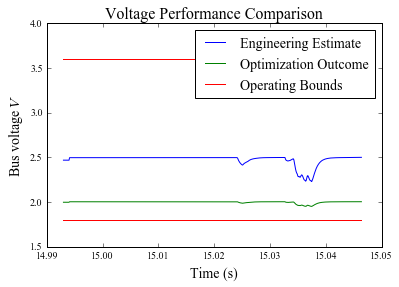

In [90]:
### SIMULATE AND PLOT OUTCOMES ####

mySim = RadioSimulator.RadioSimulator(radioFile = '../Data/PowerMEMS_Sample_Data_em_20160707.csv')
# initVariables = {'TEGserial':30, 'TEGparallel':1, 'batts':21, 'caps':1, 'SOC':0.4, 'V_b':0, 'V_c':2}
initVariables = {'TEGserial':25, 'TEGparallel':1, 'batts':1, 'caps':5, 'SOC':0.4, 'V_b':0, 'V_c':2.0}
(feasible,optimalDf,failStep) = mySim.simulate(initVariables, stopOnError=False, returnDf=True)

initVariables = {'TEGserial':64, 'TEGparallel':1, 'batts':0, 'caps':1, 'SOC':0.4, 'V_b':0, 'V_c':2.2}
(feasible,crudeDf,failStep) = mySim.simulate(initVariables, stopOnError=False, returnDf=True)

# Plotting
startAt = 40
plotLength = optimalDf.shape[0]-startAt

crudeHdl, = plt.plot(optimalDf.loc[startAt:,'time']-0.007, crudeDf.loc[startAt:,'V'], color='blue')
optHdl,   = plt.plot(optimalDf.loc[startAt:,'time']-0.007, optimalDf.loc[startAt:,'V'], color='green')
lowBnd,   = plt.plot(optimalDf.loc[startAt:,'time']-0.007, [1.8]*plotLength, color='red')
hiBnd,    = plt.plot(optimalDf.loc[startAt:,'time']-0.007, [3.6]*plotLength, color='red')
plt.legend([crudeHdl,optHdl,lowBnd],['Engineering Estimate','Optimization Outcome','Operating Bounds'],fontsize=fs)#,loc='right')
plt.ylabel('Bus voltage $V$ ',fontsize = fs)
plt.xlabel('Time (s)', fontsize = fs)
plt.title('Voltage Performance Comparison', fontsize = fs+2)

In [83]:
optimalDf.head()

,time,I_r,dt,SOC,V_b,V_c,I_t,I_b,I_c,V,OCV,dV_b,dV_c,dSOC
0,0.0,0.000011,0.1,0.400000,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,0.000011,0.1,0.400001,0.000045,2.000074,0.000254,-0.000009,-0.000047,2.001945,2.000001,0.000452,0.000736,0.000005
2,0.2,0.000011,0.1,0.400001,0.000049,2.000147,0.000254,-0.000010,-0.000047,2.002015,2.000003,0.000037,0.000734,0.000005
3,0.3,0.000005,0.1,0.400002,0.000052,2.000222,0.000254,-0.000010,-0.000048,2.002132,2.000004,0.000029,0.000755,0.000005
4,0.4,0.000009,0.1,0.400002,0.000053,2.000296,0.000254,-0.000011,-0.000047,2.002173,2.000005,0.000010,0.000738,0.000006


In [84]:
optimalDf.tail()

,time,I_r,dt,SOC,V_b,V_c,I_t,I_b,I_c,V,OCV,dV_b,dV_c,dSOC
234,15.0518,0.000011,0.0004,0.400257,0.000062,2.009537,0.000248,-0.000052,-0.000037,2.011017,2.000641,0.039201,0.000539,0.000027
235,15.0522,0.000010,0.0004,0.400257,0.000076,2.009537,0.000248,-0.000052,-0.000037,2.011028,2.000642,0.036279,0.000545,0.000027
236,15.0526,0.000011,0.0004,0.400257,0.000090,2.009537,0.000248,-0.000051,-0.000037,2.011024,2.000642,0.033512,0.000543,0.000027
237,15.0530,0.000008,0.0004,0.400257,0.000102,2.009537,0.000248,-0.000052,-0.000038,2.011049,2.000642,0.031088,0.000555,0.000027
238,15.0534,0.000009,0.0004,0.400257,0.000114,2.009538,0.000248,-0.000051,-0.000038,2.011039,2.000642,0.028682,0.000550,0.000027


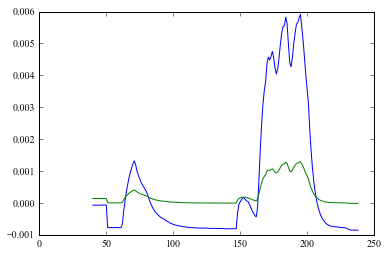

In [92]:
crudeHdl, = plt.plot(crudeDf.loc[startAt:,'I_c'], color='blue')
optHdl,   = plt.plot(optimalDf.loc[startAt:,'I_c'], color='green')


In [70]:
initVariables = {'TEGserial':28, 'TEGparallel':1, 'batts':4, 'caps':4, 'SOC':0.4, 'V_b':0, 'V_c':2.0}
(feasible,optimalDf,failStep) = mySim.simulate(initVariables, stopOnError=False, returnDf=True)
print("Size: %s is feasible? %s"%(initVariables['TEGserial']*initVariables['TEGparallel']+initVariables['batts']+initVariables['caps'],feasible))

Size: 36 is feasible? True


In [94]:
initVariables = {'TEGserial':25, 'TEGparallel':1, 'batts':1, 'caps':5, 'SOC':0.4, 'V_b':0, 'V_c':2.0}
(feasible,optimalDf,failStep) = mySim.simulate(initVariables, stopOnError=False, returnDf=True)
print("Size: %s is feasible? %s"%(initVariables['TEGserial']*initVariables['TEGparallel']+initVariables['batts']+initVariables['caps'],feasible))

Size: 31 is feasible? True


In [96]:
initVariables = {'TEGserial':64, 'TEGparallel':1, 'batts':0, 'caps':1, 'SOC':0.4, 'V_b':0, 'V_c':2.2}
(feasible,crudeDf,failStep) = mySim.simulate(initVariables, stopOnError=False, returnDf=True)
print("Size: %s is feasible? %s"%(initVariables['TEGserial']*initVariables['TEGparallel']+initVariables['batts']+initVariables['caps'],feasible))

Size: 65 is feasible? False
